<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Load" data-toc-modified-id="Sample-Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Load</a></span></li><li><span><a href="#Coherence" data-toc-modified-id="Coherence-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Coherence</a></span><ul class="toc-item"><li><span><a href="#Comparison-of-models" data-toc-modified-id="Comparison-of-models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comparison of models</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append('../code')

from utils import get_samples
from visualization import visualize_coherence, visualize_coherence_models

import warnings
warnings.filterwarnings('ignore')

# Sample Load

In [2]:
original_images_mnist, original_target_mnist, pre_images_mnist, mnist_classes, mnist_cnn = get_samples('mnist')
_, _, _, _, mnist_cnn_CBAM = get_samples('mnist',attention='CBAM')
_, _, _, _, mnist_RAN = get_samples('mnist',attention='RAN')

Data Complete
filename:  simple_cnn_mnist
Model Complete
Data Complete
filename:  simple_cnn_mnist_CBAM
Model Complete
Data Complete
filename:  mnist_RAN


In [3]:
original_images_cifar10, original_target_cifar10, pre_images_cifar10, cifar10_classes, cifar10_cnn = get_samples('cifar10')
_, _, _, _, cifar10_cnn_CBAM = get_samples('cifar10',attention='CBAM')
_, _, _, _, cifar10_RAN = get_samples('cifar10',attention='RAN')

Files already downloaded and verified
Files already downloaded and verified
Data Complete
filename:  simple_cnn_cifar10
Model Complete
Files already downloaded and verified
Files already downloaded and verified
Data Complete
filename:  simple_cnn_cifar10_CBAM
Model Complete
Files already downloaded and verified
Files already downloaded and verified
Data Complete
filename:  cifar10_RAN


# Coherence

**Model**
- Simple CNN

**Methods**
- Vanilla Backpropagation (VBP)
- Input x Backpropagation (IB)
- DeconvNet
- Integrated Gradients (IG)
- Gradient Backpropagation (GB) 
- Grad CAM (GC)
- Guided Grad-CAM (GBGC)

In [8]:
methods = ['VBP','IB','DeconvNet','IG','GB','GC','GBGC']

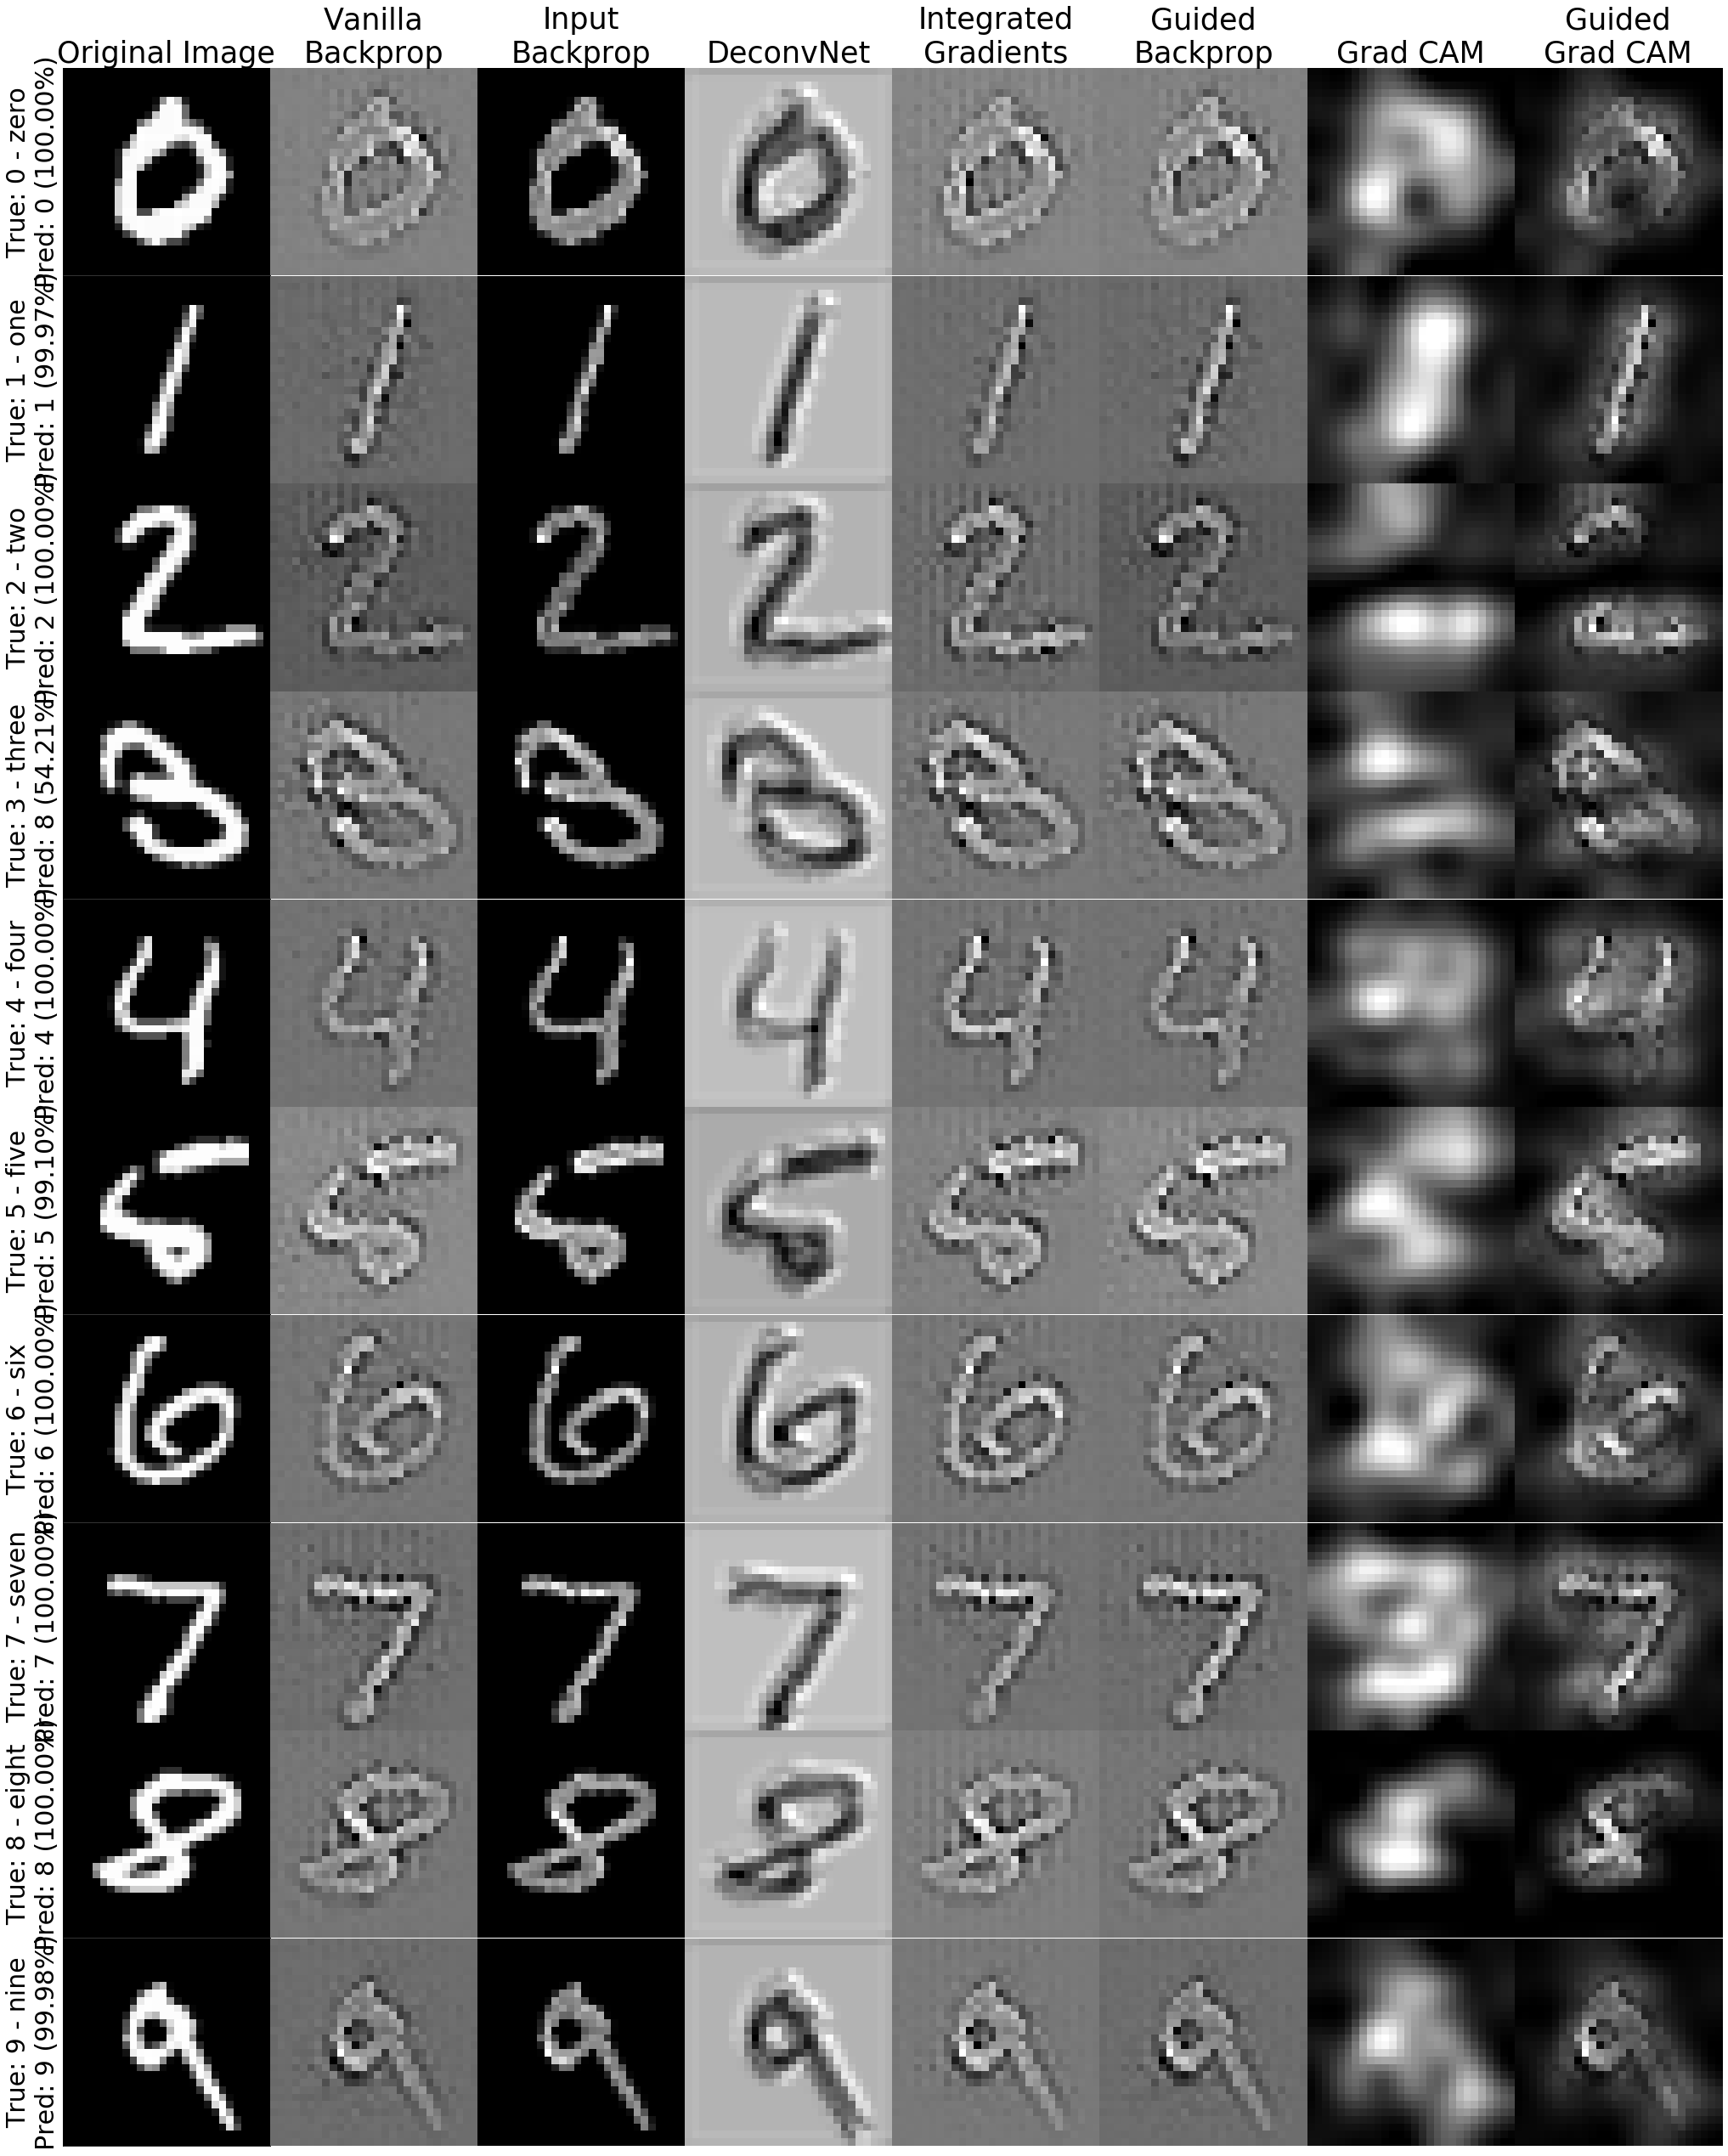

In [9]:
visualize_coherence('mnist',
                    original_images_mnist, 
                    pre_images_mnist, 
                    original_target_mnist, 
                    mnist_classes, 
                    mnist_cnn, 
                    methods,
                    '../images/results/coherence_mnist.jpg',
                    size=(35,45),
                    fontsize=35,
                    dpi=150)

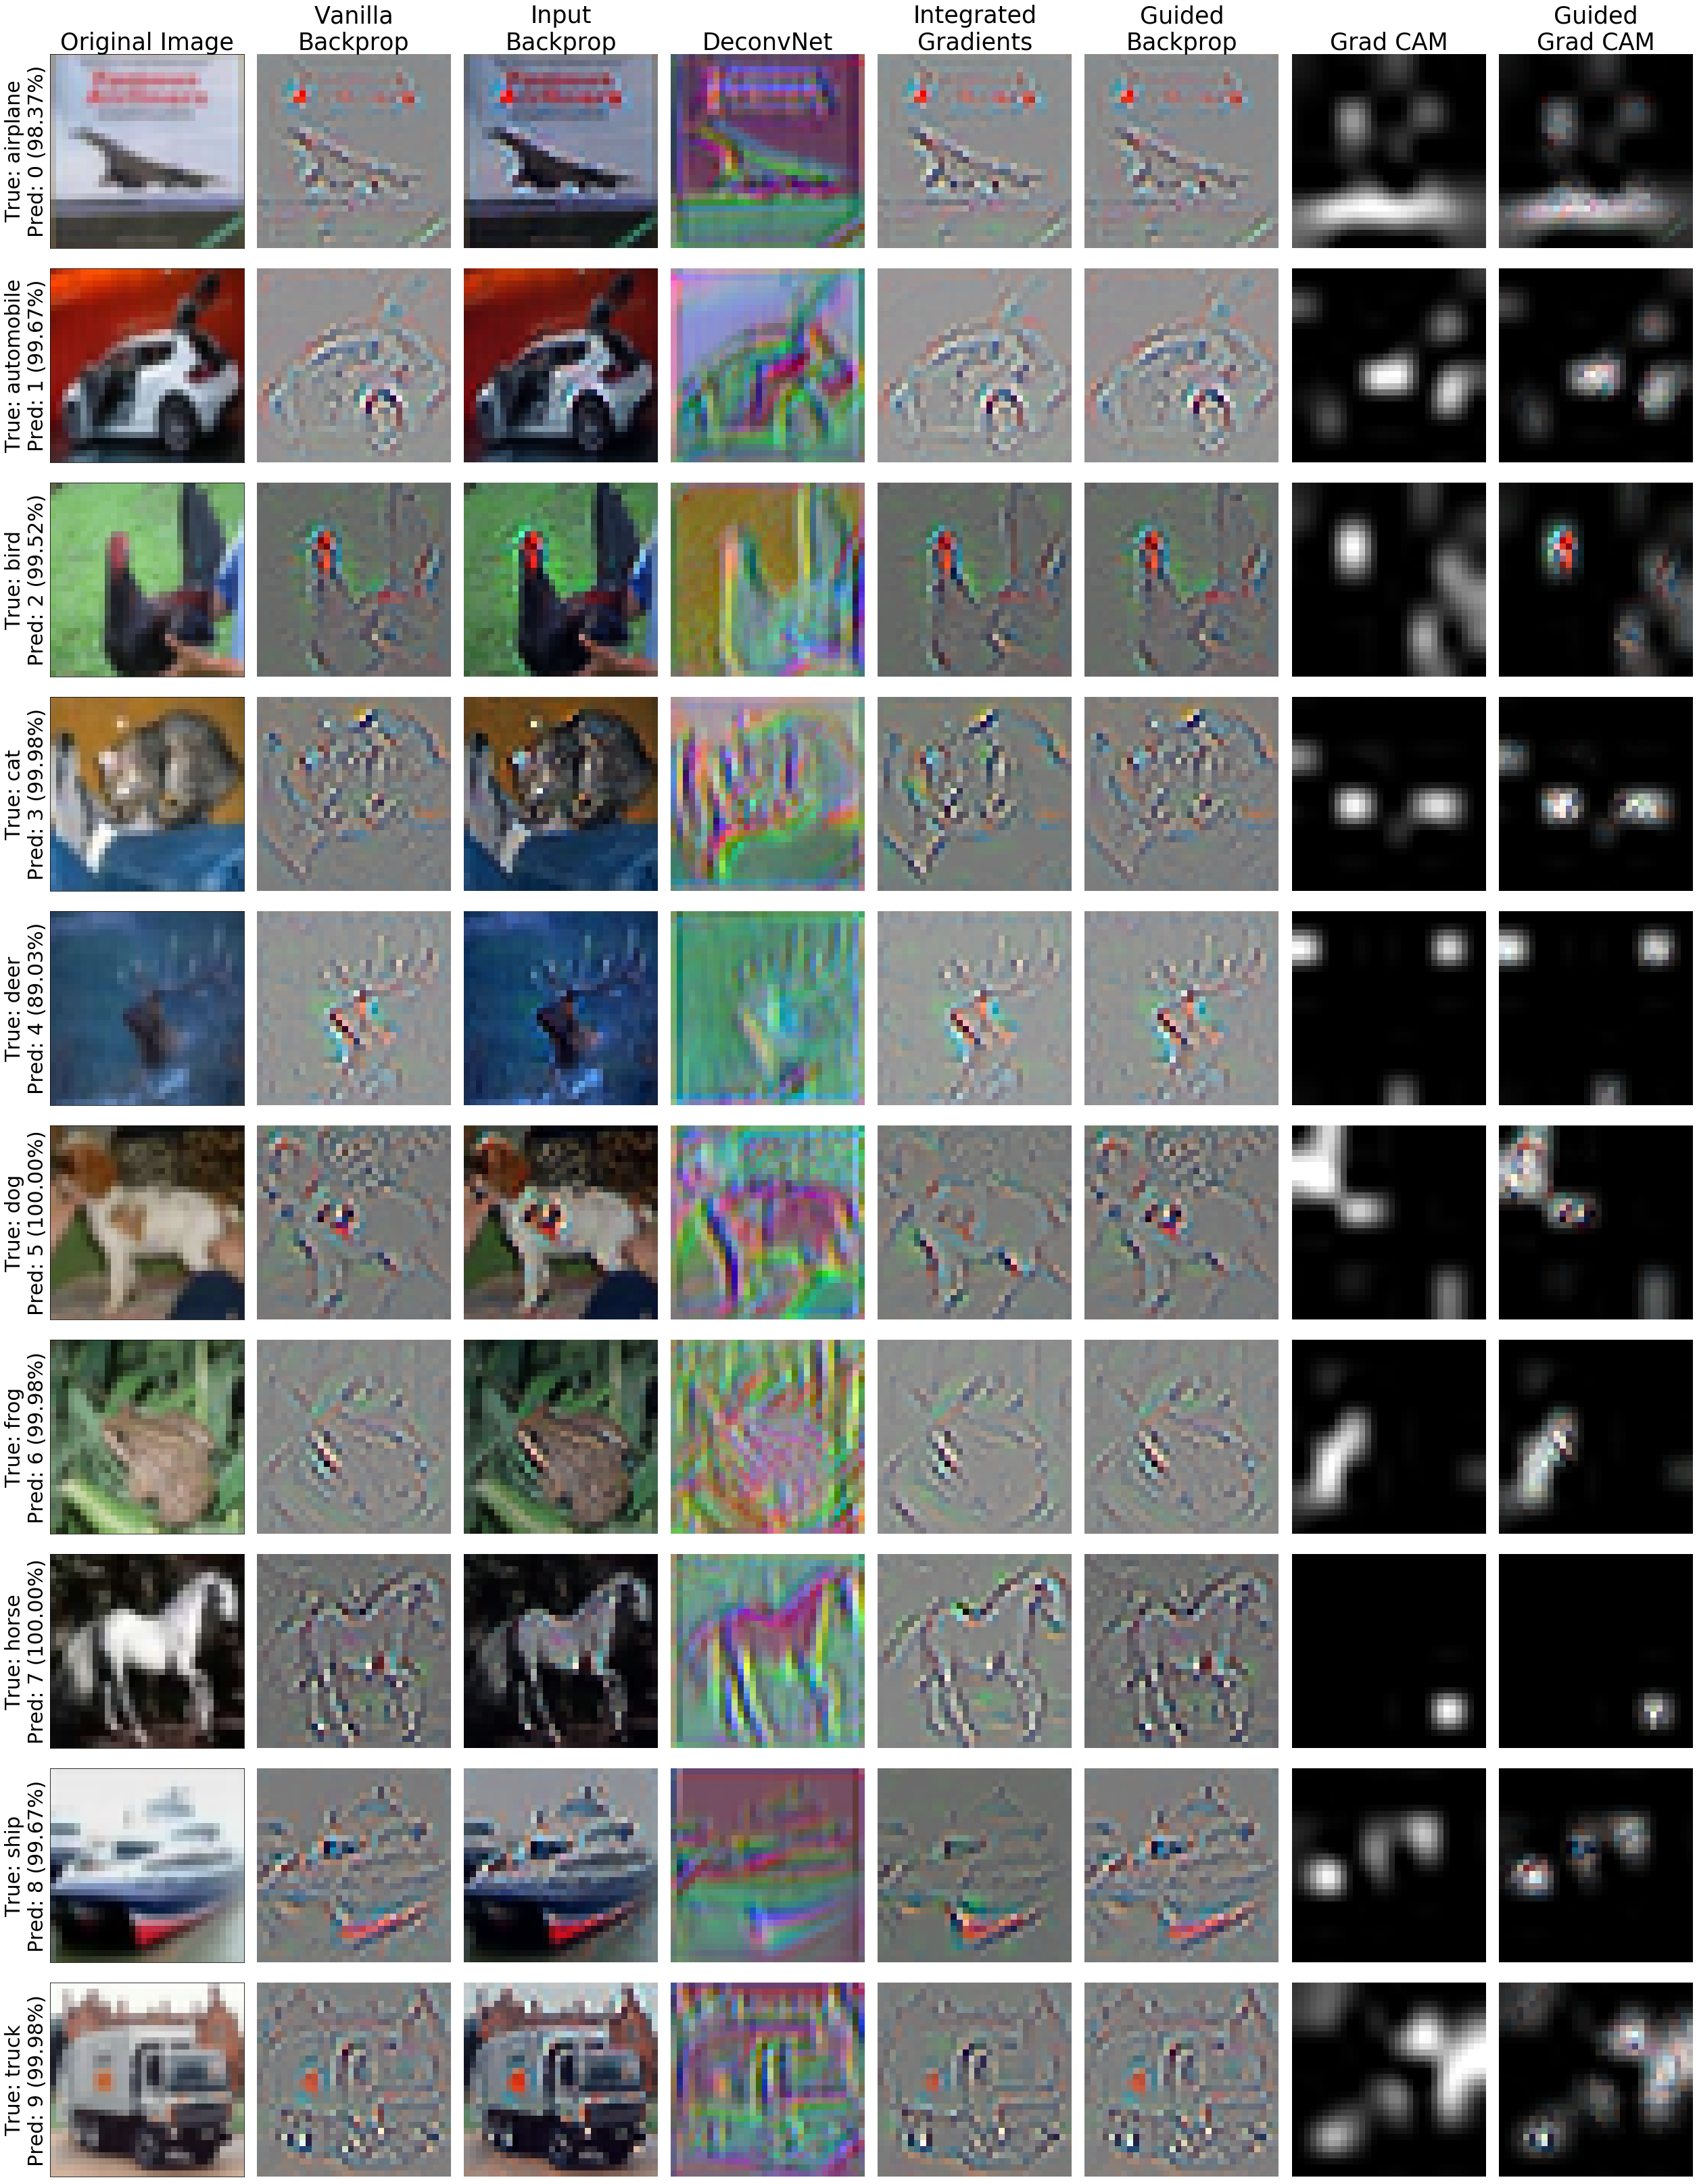

In [6]:
visualize_coherence('cifar10',
                    original_images_cifar10, 
                    pre_images_cifar10, 
                    original_target_cifar10, 
                    cifar10_classes, 
                    cifar10_cnn, 
                    methods,
                    '../images/results/coherence_cifar10.jpg',
                    size=(35,45),
                    fontsize=35,
                    dpi=150)